In [54]:
import torch
import os
import numpy as np
from Hang.utils_u_groupnorm_pytorchLightning import *
from utils import *
import time as time
import nibabel as nib
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(0)
random.seed(5)
torch.manual_seed(0)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [55]:
def loadData(numbers, numTE, usingSR, nClasses, SNR=200, getLesion = True):
    mask_files = getMaskFilenames(numbers)
    lesion_mask_files = getLesionMaskFilenames(numbers)
    fastt2_files = getRealBrainFilenames(numbers) \
                   if numTE == 6 \
                   else getSimulated32TE(numbers, SNR)
    label_files = getLabelFilenamesAsMWF(numbers, usingSR) \
                  if nClasses == 1 \
                  else getLabelFilenamesAsWeights(numbers)
    
    mask_array = loadMasks(mask_files)
    lesion_mask_array = loadLesionMasks(lesion_mask_files) if getLesion else None
    brains = loadBrains(fastt2_files, mask_array)
    labels = loadLabels(label_files, mask_array)
    
    if numTE == 6 and usingSR and nClasses == 1 and "2245" in numbers:
        subj2245Idx = numbers.index("2245")
        mask2245 = mask_array[subj2245Idx][None]
        lesion2245 = lesion_mask_array[subj2245Idx][None]
        label2245 = labels[subj2245Idx][None]
        brain2245 = nib.load("../2245/FAST_T2_NO_NOISE.nii.gz").get_fdata()
        brain2245 = brain2245.transpose((3,0,1,2))[None]
        return labels, brains, mask_array, lesion_mask_array, \
               label2245, brain2245, mask2245, lesion2245
    return labels, brains, mask_array, lesion_mask_array

In [56]:
from Hang.unet3dPersonalGroupNorm_pytorchLightning import unet3d_tuning
from Hang.annPersonalBatchNorm_pytorchLightning import ann_256_256_32, ann_big

In [57]:
def calculateResultsErrorTableMLP(state_dict, 
                                  stats, 
                                  testBrains, 
                                  testLabels, 
                                  testMasks, 
                                  numbers, 
                                  lesions = None, 
                                  save=False, 
                                  brainType = "real", 
                                  lesion = False, 
                                  nClasses = 1, 
                                  inChannels = 6, 
                                  folder = "", 
                                  norm = True):
    featureNumPaths = ["MWF"] if nClasses == 1 \
                      else ["MWF", "IEWF", "CSFF", "MWF_T2", "IEWF_T2", "CSFF_T2"]
    model = ann_256_256_32(0.01, 
                           [256,256,32], 
                           n_classes = nClasses, 
                           in_channels = inChannels).float() if inChannels == 6 \
            else ann_big(0.01, 
                         [256,256,32], 
                         n_classes = nClasses, 
                         in_channels = inChannels).float()
    state_dict = torch.load(state_dict, map_location='cpu')
    model.load_state_dict(state_dict["state_dict"])
    model = model.float().to(device)
    model.eval()
    results = {}
    for i in range(nClasses):
        results[i] = []
    size = testBrains.shape[2:]  # 256, 256, 32
    times = []
    
    for idx in range(len(testBrains)):
        start = time.time()
        number = numbers[idx]
        signal = np.divide(testBrains[idx], testBrains[idx][0] + 1e-16) if norm else testBrains[idx]
        # signal shape: num_features, 256, 256, 32
        signal = signal.swapaxes(1,3)
        # signal shape: num_features, 32, 256, 256
        signal = signal.reshape(inChannels,size[2],-1).swapaxes(0,2) 
        # signal shape: -1, 32, num_features
        output = np.zeros((1,nClasses,size[1],size[0],size[2]))  # 1, nClasses, 256, 256, 32
        for i in range(size[2]):  # 32
            out = model(torch.tensor(signal[:,i]).float().to(device)).to(device)
            out = out.reshape(size[1],size[0],-1).permute(2,0,1)  # -1, 256, 256
            output[0,:,:,:,i] = out.detach().cpu().numpy() 
        label = testLabels[idx].copy()
        for i in range(nClasses):
            output[0,i] *= stats[i][1]
            output[0,i] += stats[i][0]
            
        if nClasses == 6:
            guess_sum = output[0,0]+output[0,1]+output[0,2]+1e-16
            output[0,0] /= guess_sum
            output[0,1] /= guess_sum
            output[0,2] /= guess_sum
            output[0,0] *= 100
            output[0,1] *= 100
            output[0,2] *= 100
        if len(label) == 6:
            label_sum = label[0] + label[1] + label[2]+1e-16
            label[0] /= label_sum
            label[1] /= label_sum
            label[2] /= label_sum
            label[0] *= 100
            label[1] *= 100
            label[2] *= 100

        label = np.nan_to_num(label)
        output = np.nan_to_num(output)
        mask = testMasks[idx]
        output = output[0].swapaxes(1,2)

        for feature_num in range(len(label)):
            min_max = [0, 100] if feature_num == 0 else [-3000, 3000]
            brain = np.clip(output[feature_num] * mask, min_max[0], min_max[1])
            label_big = label[feature_num] * mask
            error = abs(-label_big+brain)
#             error = -label_big+brain  # TODO: REINSERT THE ABSOLUTE VALUE SIGN! DO NOT SAVE THESE RESULTS!
            if (lesion):
                lesionMask = lesions[idx]
                if (lesionMask.sum() == 0):
                    continue
                error = error[lesionMask == 1]
                results[feature_num].append((number, np.mean(error)))
            else:
                error = error[mask == 1]
                results[feature_num].append((number, np.mean(error)))
                if (save):
                    sample = f"../{number}/MWF.nii.gz"
                    base = f"results_v3/{folder}/{featureNumPaths[feature_num]}"
                    save_nii(brain, 
                             f"{base}/{number}_pred_MLP_{brainType}.nii.gz", 
                             sample)
                    save_nii(label_big, 
                             f"{base}/{number}_label_MLP_{brainType}.nii.gz", 
                             sample)
                    save_nii(brain-label_big, 
                             f"{base}/{number}_err_MLP_{brainType}.nii.gz", 
                             sample)
                    if feature_num == 0:
                        end = time.time()
                        times.append(end-start)
#     print(np.array(times).mean())
    return results

In [58]:
def calculateResultsErrorTableUNETTuning(state_dict, 
                                         stats, 
                                         testBrains, 
                                         testLabels, 
                                         testMasks, 
                                         numbers, 
                                         lesions = None, 
                                         save=False, 
                                         brainType = "real", 
                                         lesion = False, 
                                         nClasses = 1,  
                                         inChannels = 6,
                                         folder = "", 
                                         norm = True):
    featureNumPaths = ["MWF"] if nClasses == 1 \
                      else ["MWF", "IEWF", "CSFF", "MWF_T2", "IEWF_T2", "CSFF_T2"]
    model = unet3d_tuning(0.01, n_classes=nClasses, in_channels=inChannels).float() 
    state_dict = torch.load(state_dict, map_location='cpu')
    model.load_state_dict(state_dict["state_dict"])
    model = model.float().to(device)
    model.eval()
    results = {}
    for i in range(nClasses):
        results[i] = []
    size = testBrains.shape[2:]
    times = []

    for idx in range(len(testBrains)): 
        start = time.time()
        number = numbers[idx]
        mask = testMasks[idx]
        signal = np.divide(testBrains[idx], testBrains[idx][0] + 1e-16)[None] if norm else testBrains[idx][None]
        output = model(torch.tensor(signal).float().to(device)).to(device)
        label = testLabels[idx].copy()
        for i in range(nClasses):
            output[0,i] *= stats[i][1]
            output[0,i] += stats[i][0]
        output = output.detach().cpu().numpy()
        
        if nClasses == 6:
            guess_sum = output[0,0]+output[0,1]+output[0,2]+1e-16
            output[0,0] /= guess_sum
            output[0,1] /= guess_sum
            output[0,2] /= guess_sum
            output[0,0] *= 100
            output[0,1] *= 100
            output[0,2] *= 100
        if len(label) == 6:
            label_sum = label[0] + label[1] + label[2]+1e-16
            label[0] /= label_sum
            label[1] /= label_sum
            label[2] /= label_sum
            label[0] *= 100
            label[1] *= 100
            label[2] *= 100

        label = np.nan_to_num(label).astype(float)
        output = np.nan_to_num(output).astype(float)
        output = output[0]
        
        for feature_num in range(len(label)):
            min_max = [0, 100] if feature_num < 3 else [-3000, 3000]
            brain = np.clip(output[feature_num] * mask, min_max[0], min_max[1])
            label_big = label[feature_num] * mask
            error = abs(-label_big+brain)
#             error = -label_big+brain  # TODO: REINSERT THE ABSOLUTE VALUE SIGN! DO NOT SAVE THESE RESULTS!
            if lesion:
                lesionMask = lesions[idx]
                if (lesionMask.sum() == 0):
                    continue
                error = error[lesionMask == 1]
                results[feature_num].append((number, np.mean(error)))
            else:
                error = error[mask == 1]
                results[feature_num].append((number, np.mean(error)))
                if save:
                    sample = f"../{number}/MWF.nii.gz"
                    feature = featureNumPaths[feature_num]
                    base = f"results_v3/{folder}/{feature}"
                    save_nii(brain, 
                             f"{base}/{number}_pred_UNET_{feature}_{brainType}.nii.gz", 
                             sample)
                    save_nii(label_big, 
                             f"{base}/{number}_label_UNET_{feature}_{brainType}.nii.gz", 
                             sample)
                    save_nii(brain-label_big, 
                             f"{base}/{number}_err_UNET_{feature}_{brainType}.nii.gz", 
                             sample)
                    if feature_num == 0:
                        end = time.time()
                        times.append(end-start)
#     print(np.array(times).mean())
    return results

# 1. Test Dataset 1

In [59]:
numbers = ["0001","0017","0018","0038","0040","0042","0046","0087","0090","0108","0116","0131","0178","0190",
           "0227","0248","0267","0282","0285","0398","0448","0466","0504","0514","0535","0564","0598","0606",
           "0607","0618","0620","0623","0642","0646","0655","0668","0675","0681","0719","0761","0762","0783",
           "0786","0868","0877","0887","0895","0902","0931","0979","1007","1013","1029","1033","1068","1142",
           "1143","1163","1190","1260","1275","1347","1383","1389","1416","1435","1441","1447","1451","1514",
           "1520","1602","1611","1621","1680","1684","1686","1710","1720","1739","1743","1749","1753","1760",
           "1795","1805","1845","1858","1876","1889","1892","1898","1899","1918","1924","1932","1952","1961",
           "1972","1987","2003","2007","2016","2020","2022","2030","2045","2047","2049","2053","2055","2074",
           "2077","2080","2091","2094","2103","2115","2128","2142","2144","2146","2152","2156","2158","2160",
           "2161","2179","2180","2181","2183","2186","2188","2212","2221","2231","2234","2245"]
SPLIT = 50
numbers = numbers[SPLIT + 25:]
SIM_BRAIN = '2245'

## 1.5 Test MWF pred w/SR w/6 echoes w/6 outputs

In [7]:
labels, brains, mask_array, lesion_mask_array = loadData(numbers, 6, True, 6)

In [8]:
stats = getStats(6, True, 6)

### 1.5.a UNET

In [20]:
# %ls results_v3
# !mkdir "results_v3/tmp"
# !mkdir "results_v3/tmp/MWF"
# !mkdir "results_v3/tmp/IEWF"
# !mkdir "results_v3/tmp/CSFF"
# !mkdir "results_v3/tmp/MWF_T2"
# !mkdir "results_v3/tmp/IEWF_T2"
# !mkdir "results_v3/tmp/CSFF_T2"

In [9]:
state_dict = "../unet_models/unet_6_classes_2_accum_ckpt_epoch_38.ckpt"

In [16]:
results_unet_sr_mwf_6_echo_6_classes = calculateResultsErrorTableUNETTuning(state_dict, stats,   
                                                                            brains, labels,
                                                                            mask_array, numbers,
                                                                            save=True, 
                                                                            folder="unet-sr-mwf-6-echo-6-classes",
                                                                            nClasses = 6)

0.6744383138323587


In [17]:
for j in range(6):
    data = [i[1] for i in results_unet_sr_mwf_6_echo_6_classes[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.501±0.074
0.841±0.109
0.606±0.089
1.078±0.093
1.308±0.241
0.021±0.010


In [12]:
results_unet_sr_mwf_6_echo_6_classes_lesion = calculateResultsErrorTableUNETTuning(state_dict, stats, 
                                                                                   brains, labels, 
                                                                                   mask_array, numbers,
                                                                                   lesions=lesion_mask_array, 
                                                                                   lesion=True,
                                                                                   save=False, 
                                                                                   nClasses = 6)

In [13]:
for j in range(6):
    data = [i[1] for i in results_unet_sr_mwf_6_echo_6_classes_lesion[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.507±0.206
0.772±0.285
0.648±0.280
1.217±0.282
2.137±1.344
0.018±0.009


In [13]:
state_dict = "../unet_models/unet_no_norm_6_classes_ckpt_epoch_17.ckpt"

In [133]:
results_unet_sr_mwf_6_echo_6_classes_no_norm = calculateResultsErrorTableUNETTuning(state_dict, stats,   
                                                                                    brains, labels,
                                                                                    mask_array, numbers,
                                                                                    save=False, norm = False,
                                                                                    nClasses = 6)

In [134]:
for j in range(6):
    data = [i[1] for i in results_unet_sr_mwf_6_echo_6_classes_no_norm[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.559±0.063
1.417±0.135
1.198±0.146
1.168±0.152
1.334±0.296
0.026±0.012


In [135]:
results_unet_sr_mwf_6_echo_6_classes_no_norm_lesion = calculateResultsErrorTableUNETTuning(state_dict, stats, 
                                                                                           brains, labels, 
                                                                                           mask_array, numbers,
                                                                                           lesions=lesion_mask_array, 
                                                                                           lesion=True,
                                                                                           save=False, norm = False,
                                                                                           nClasses = 6)

In [136]:
for j in range(6):
    data = [i[1] for i in results_unet_sr_mwf_6_echo_6_classes_no_norm_lesion[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.460±0.091
1.885±0.394
1.750±0.428
1.394±0.346
1.644±0.989
0.016±0.007


### 1.5.b MLP

In [78]:
# %ls results_v3
# !mkdir "results_v3/mlp-sr-mwf-6-echo-6-classes"
# !mkdir "results_v3/mlp-sr-mwf-6-echo-6-classes/MWF"
# !mkdir "results_v3/mlp-sr-mwf-6-echo-6-classes/IEWF"
# !mkdir "results_v3/mlp-sr-mwf-6-echo-6-classes/CSFF"
# !mkdir "results_v3/mlp-sr-mwf-6-echo-6-classes/MWF_T2"
# !mkdir "results_v3/mlp-sr-mwf-6-echo-6-classes/IEWF_T2"
# !mkdir "results_v3/mlp-sr-mwf-6-echo-6-classes/CSFF_T2"

In [9]:
state_dict = "../mlp_models/mlp_6_classes_ckpt_epoch_4.ckpt"

In [10]:
results_mlp_sr_mwf_6_echo_6_classes = calculateResultsErrorTableMLP(state_dict, stats, 
                                                                    brains, labels, 
                                                                    mask_array, numbers, 
                                                                    save=True, 
                                                                    folder = 'tmp',
                                                                    nClasses = 6)
# mlp-sr-mwf-6-echo-6-classes

0.9242975257691883


In [11]:
for j in range(6):
    data = [i[1] for i in results_mlp_sr_mwf_6_echo_6_classes[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

1.191±0.110
1.097±0.113
0.321±0.055
1.430±0.125
1.396±0.244
0.015±0.007


In [22]:
results_mlp_sr_mwf_6_echo_6_classes_lesion = calculateResultsErrorTableMLP(state_dict, stats, 
                                                                           brains, labels, 
                                                                           mask_array, numbers, 
                                                                           lesions=lesion_mask_array, lesion=True,
                                                                           save=False, nClasses = 6)

In [23]:
for j in range(6):
    data = [i[1] for i in results_mlp_sr_mwf_6_echo_6_classes_lesion[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

1.232±0.309
1.038±0.251
0.496±0.132
1.934±0.524
1.922±0.783
0.010±0.006


In [122]:
state_dict = "../mlp_models/mlp_no_norm_6_classes_ckpt_epoch_19.ckpt"

In [123]:
results_mlp_sr_mwf_6_echo_6_classes_no_norm = calculateResultsErrorTableMLP(state_dict, stats, 
                                                                            brains, labels, 
                                                                            mask_array, numbers, 
                                                                            save=False, norm = False, 
                                                                            nClasses = 6)

In [124]:
for j in range(6):
    data = [i[1] for i in results_mlp_sr_mwf_6_echo_6_classes_no_norm[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

1.187±0.107
1.100±0.112
0.314±0.064
1.429±0.181
1.393±0.217
0.013±0.006


In [126]:
results_mlp_sr_mwf_6_echo_6_classes_no_norm_lesion = calculateResultsErrorTableMLP(state_dict, stats, 
                                                                                   brains, labels, 
                                                                                   mask_array, numbers, 
                                                                                   lesions=lesion_mask_array, 
                                                                                   lesion=True, norm = False,
                                                                                   save=False, nClasses = 6)

In [127]:
for j in range(6):
    data = [i[1] for i in results_mlp_sr_mwf_6_echo_6_classes_no_norm_lesion[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

1.158±0.321
1.064±0.288
0.396±0.185
2.019±0.559
2.027±0.831
0.013±0.004


In [109]:
from scipy.stats import ttest_ind, ranksums, probplot

In [128]:
for j in range(6):
    print(ttest_ind([i[1] for i in results_mlp_sr_mwf_6_echo_6_classes_no_norm_lesion[j]],
                    [i[1] for i in results_mlp_sr_mwf_6_echo_6_classes_lesion[j]]))

Ttest_indResult(statistic=-1.2416173070810879, pvalue=0.21697173565756062)
Ttest_indResult(statistic=0.5156750313033859, pvalue=0.6070978496113739)
Ttest_indResult(statistic=-3.302768467032576, pvalue=0.0012855081896466826)
Ttest_indResult(statistic=0.831976947953199, pvalue=0.4071923493432299)
Ttest_indResult(statistic=0.6944423453238636, pvalue=0.48884286863560245)
Ttest_indResult(statistic=3.312657072252836, pvalue=0.0012448563362016617)


In [125]:
for j in range(6):
    print(ttest_ind([i[1] for i in results_mlp_sr_mwf_6_echo_6_classes_no_norm[j]],
                    [i[1] for i in results_mlp_sr_mwf_6_echo_6_classes[j]]))

Ttest_indResult(statistic=-0.20465379384899687, pvalue=0.8381781652188417)
Ttest_indResult(statistic=0.13827974183496072, pvalue=0.8902436421868056)
Ttest_indResult(statistic=-0.6851353027664969, pvalue=0.4945373076448444)
Ttest_indResult(statistic=-0.03548281353134575, pvalue=0.9717518072666277)
Ttest_indResult(statistic=-0.08286056334930705, pvalue=0.9340960231511741)
Ttest_indResult(statistic=-1.5476739568264262, pvalue=0.1242492804865037)


In [31]:
for j in range(6):
    print(ranksums([i[1] for i in results_unet_sr_mwf_6_echo_6_classes[j]],
                    [i[1] for i in results_mlp_sr_mwf_6_echo_6_classes[j]]))

RanksumsResult(statistic=-9.682763320034782, pvalue=3.569355687242394e-22)
RanksumsResult(statistic=-8.755716189368817, pvalue=2.028114762891134e-18)
RanksumsResult(statistic=9.565662629845399, pvalue=1.1148499862703548e-21)
RanksumsResult(statistic=-9.502233089326147, pvalue=2.0543672611285425e-21)
RanksumsResult(statistic=-2.3054198381035196, pvalue=0.021143071510364896)
RanksumsResult(statistic=4.0716885817934125, pvalue=4.667355302507867e-05)


In [30]:
for j in range(6):
    print(ranksums([i[1] for i in results_unet_sr_mwf_6_echo_6_classes_lesion[j]],
                    [i[1] for i in results_mlp_sr_mwf_6_echo_6_classes_lesion[j]]))

RanksumsResult(statistic=-8.877634206043329, pvalue=6.82974096306591e-19)
RanksumsResult(statistic=-6.293401076164134, pvalue=3.105844677142482e-10)
RanksumsResult(statistic=3.816844326696573, pvalue=0.00013516939355084253)
RanksumsResult(statistic=-7.443838193193688, pvalue=9.780128078831041e-14)
RanksumsResult(statistic=0.3485314418587071, pvalue=0.7274411050772472)
RanksumsResult(statistic=6.775111199058283, pvalue=1.2431061023766396e-11)


### 1.5.c Saving

In [32]:
np.save("dataset-1-mwf-pred-w-sr-6-echo-6-classes-whole-brain-bn.npy", 
        [results_unet_sr_mwf_6_echo_6_classes, results_mlp_sr_mwf_6_echo_6_classes])

np.save("dataset-1-mwf-pred-w-sr-6-echo-6-classes-lesion-bn.npy", 
        [results_unet_sr_mwf_6_echo_6_classes_lesion, results_mlp_sr_mwf_6_echo_6_classes_lesion])

## 1.1 Test MWF pred w/SR w/6 echoes

In [17]:
labels, brains, mask_array, lesion_mask_array, \
label2245, brain2245, mask2245, lesion2245 = loadData(numbers, 6, True, 1)

In [18]:
stats = getStats(6, True, 1)

### 1.1.a UNET

In [19]:
state_dict = "../unet_models/unet_mwf_only_plus_sr_ckpt_epoch_30.ckpt"

In [147]:
# %ls results_v3
# !mkdir "results_v3/unet-sr-mwf-6-echo"
# !mkdir "results_v3/unet-sr-mwf-6-echo/MWF"

In [20]:
results_unet_sr_mwf_6_echo = calculateResultsErrorTableUNETTuning(state_dict, stats, 
                                                                  brains, labels, 
                                                                  mask_array, numbers, 
                                                                  save=True, folder="unet-sr-mwf-6-echo")

In [21]:
for j in range(1):
    data = [i[1] for i in results_unet_sr_mwf_6_echo[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.440±0.071


In [22]:
results_unet_sr_mwf_6_echo_lesion = calculateResultsErrorTableUNETTuning(state_dict, stats, 
                                                                         brains, labels, 
                                                                         mask_array, numbers,
                                                                         lesions=lesion_mask_array, lesion=True,
                                                                         save=False)

In [23]:
for j in range(1):
    data = [i[1] for i in results_unet_sr_mwf_6_echo_lesion[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.402±0.138


### 1.1.b MLP

In [154]:
# %ls results_v3
# !mkdir "results_v3/mlp-sr-mwf-6-echo"
# !mkdir "results_v3/mlp-sr-mwf-6-echo/MWF"

In [22]:
state_dict = "../mlp_models/mlp_mwf_only_plus_sr_ckpt_epoch_12.ckpt"

In [23]:
results_mlp_sr_mwf_6_echo = calculateResultsErrorTableMLP(state_dict, stats, 
                                                          brains, labels, 
                                                          mask_array, numbers, 
                                                          save=True, folder="mlp-sr-mwf-6-echo")

In [24]:
for j in range(1):
    data = [i[1] for i in results_mlp_sr_mwf_6_echo[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

1.153±0.121


In [27]:
results_mlp_sr_mwf_6_echo_lesion = calculateResultsErrorTableMLP(state_dict, stats, 
                                                                 brains, labels, 
                                                                 mask_array, numbers, 
                                                                 lesions=lesion_mask_array, lesion=True,
                                                                 save=False)

In [28]:
for j in range(1):
    data = [i[1] for i in results_mlp_sr_mwf_6_echo_lesion[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

1.236±0.330


In [23]:
print(ranksums([i[1] for i in results_unet_sr_mwf_6_echo[0]],
                [i[1] for i in results_mlp_sr_mwf_6_echo[0]]))

RanksumsResult(statistic=-9.682763320034782, pvalue=3.569355687242394e-22)


In [26]:
print(ranksums([i[1] for i in results_unet_sr_mwf_6_echo_lesion[0]],
                [i[1] for i in results_mlp_sr_mwf_6_echo_lesion[0]]))

RanksumsResult(statistic=-9.14399156811421, pvalue=6.018877684928938e-20)


### 1.1.c Saving

In [47]:
np.save("dataset-1-mwf-pred-w-sr-6-echo-whole-brain-bn.npy", 
        [results_unet_sr_mwf_6_echo, results_mlp_sr_mwf_6_echo])

In [48]:
np.save("dataset-1-mwf-pred-w-sr-6-echo-lesion-bn.npy", 
        [results_unet_sr_mwf_6_echo_lesion, results_mlp_sr_mwf_6_echo_lesion])

### Looking at error distribution for case 2103

In [49]:
mask = load_nii("../2103/tightmask.nii.gz")

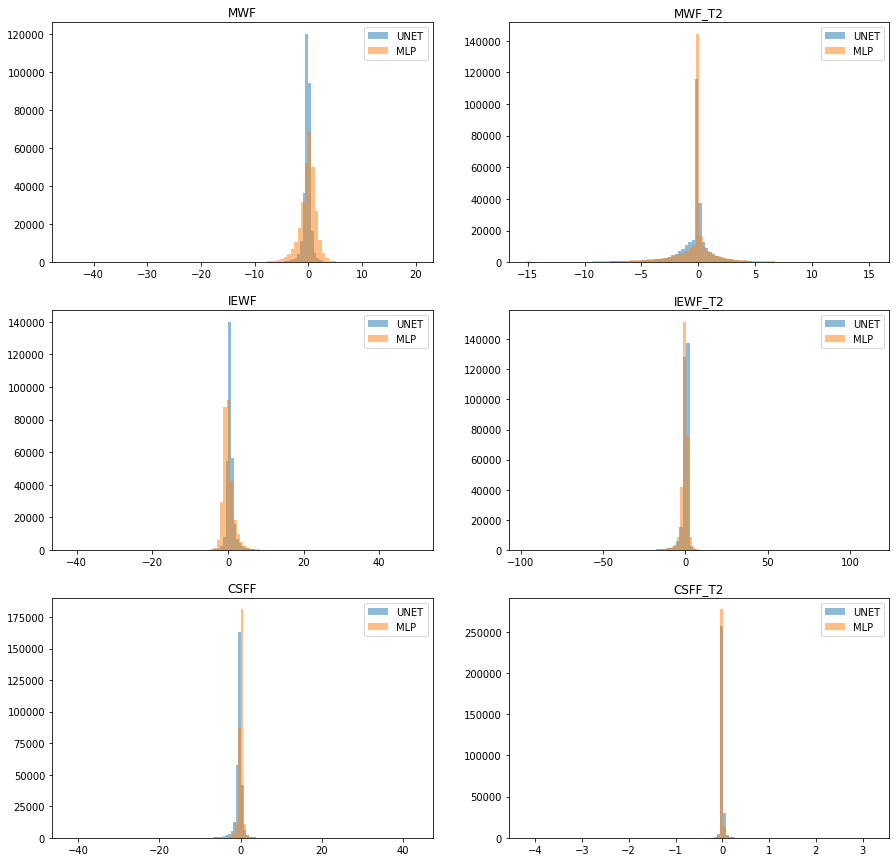

In [50]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))
for i in range(3):
    features = ["MWF", "IEWF", "CSFF"]
    feature = features[i]
    u = load_nii(f"results_v3/unet-sr-mwf-6-echo-6-classes/{feature}/2103_err_UNET_{feature}_real.nii.gz")
    l = load_nii(f"results_v3/unet-sr-mwf-6-echo-6-classes/{feature}/2103_label_UNET_{feature}_real.nii.gz")
    u = u[mask == 1]
    l = l[mask == 1]
    a = load_nii(f"results_v3/mlp-sr-mwf-6-echo-6-classes/{feature}/2103_err_MLP_real.nii.gz")[mask == 1]
    axs[i][0].hist(u, bins=100, alpha=0.5, label='UNET')
    axs[i][0].hist(a, bins=100, alpha=0.5, label='MLP')
    axs[i][0].legend(loc='best')
    axs[i][0].title.set_text(feature)
    
    feature = features[i]+"_T2"
    u = load_nii(f"results_v3/unet-sr-mwf-6-echo-6-classes/{feature}/2103_err_UNET_{feature}_real.nii.gz")
    l = load_nii(f"results_v3/unet-sr-mwf-6-echo-6-classes/{feature}/2103_label_UNET_{feature}_real.nii.gz")
    u = u[mask == 1]
    l = l[mask == 1]
    a = load_nii(f"results_v3/mlp-sr-mwf-6-echo-6-classes/{feature}/2103_err_MLP_real.nii.gz")[mask == 1]
    axs[i][1].hist(u, bins=100, alpha=0.5, label='UNET')
    axs[i][1].hist(a, bins=100, alpha=0.5, label='MLP')
    axs[i][1].legend(loc='best')
    axs[i][1].title.set_text(feature)

## 1.2 Test MWF pred w/o SR w/6 echoes

In [65]:
labels, brains, mask_array, lesion_mask_array = loadData(numbers, 6, False, 1)

In [66]:
stats = getStats(6, False, 1)

### 1.2.a UNET

In [67]:
state_dict = "../unet_models/unet_no_sr_ckpt_epoch_39.ckpt"

In [68]:
# %ls results_v3
# !mkdir "results_v3/unet-no-sr-mwf-6-echo"
# !mkdir "results_v3/unet-no-sr-mwf-6-echo/MWF"

In [69]:
results_unet_no_sr_mwf_6_echo = calculateResultsErrorTableUNETTuning(state_dict, stats,   
                                                                     brains, labels,
                                                                     mask_array, numbers,
                                                                     save=True, folder="unet-no-sr-mwf-6-echo")

In [70]:
for j in range(1):
    data = [i[1] for i in results_unet_no_sr_mwf_6_echo[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.515±0.070


In [42]:
results_unet_no_sr_mwf_6_echo_lesion = calculateResultsErrorTableUNETTuning(state_dict, stats, 
                                                                            brains, labels, 
                                                                            mask_array, numbers,
                                                                            lesions=lesion_mask_array, lesion=True,
                                                                            save=False)

In [43]:
for j in range(1):
    data = [i[1] for i in results_unet_no_sr_mwf_6_echo_lesion[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.850±0.230


### 1.2.b MLP

In [220]:
# %ls results_v3
# !mkdir "results_v3/mlp-no-sr-mwf-6-echo"
# !mkdir "results_v3/mlp-no-sr-mwf-6-echo/MWF"

In [31]:
state_dict = "../mlp_models/mlp_no_sr_ckpt_epoch_4.ckpt"

In [32]:
results_mlp_no_sr_mwf_6_echo = calculateResultsErrorTableMLP(state_dict, stats, 
                                                             brains, labels, 
                                                             mask_array, numbers, 
                                                             save=True, folder="mlp-no-sr-mwf-6-echo")

In [33]:
for j in range(1):
    data = [i[1] for i in results_mlp_no_sr_mwf_6_echo[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.303±0.050


In [47]:
results_mlp_no_sr_mwf_6_echo_lesion = calculateResultsErrorTableMLP(state_dict, stats, 
                                                                    brains, labels, 
                                                                    mask_array, numbers, 
                                                                    lesions=lesion_mask_array, lesion=True,
                                                                    save=False)

In [48]:
for j in range(1):
    data = [i[1] for i in results_mlp_no_sr_mwf_6_echo_lesion[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.411±0.138


### 1.2.c Saving

In [63]:
np.save("dataset-1-mwf-pred-wo-sr-6-echo-whole-brain-bn.npy", 
        [results_unet_no_sr_mwf_6_echo, results_mlp_no_sr_mwf_6_echo])

In [64]:
np.save("dataset-1-mwf-pred-wo-sr-6-echo-lesion-bn.npy", 
        [results_unet_no_sr_mwf_6_echo_lesion, results_mlp_no_sr_mwf_6_echo_lesion])

In [28]:
print(ranksums([i[1] for i in results_mlp_no_sr_mwf_6_echo_lesion[0]],
                [i[1] for i in results_unet_no_sr_mwf_6_echo_lesion[0]]))

RanksumsResult(statistic=-8.242910279406333, pvalue=1.680716054210941e-16)


In [29]:
print(ranksums([i[1] for i in results_mlp_no_sr_mwf_6_echo[0]],
                [i[1] for i in results_unet_no_sr_mwf_6_echo[0]]))

RanksumsResult(statistic=-9.492474698477032, pvalue=2.2561338478986385e-21)


## 1.3 Test MWF Pred w/SR w/32 echoes

In [52]:
labels, brains, mask_array, lesion_mask_array = loadData(numbers, 32, True, 1, 200)

In [53]:
stats = getStats(32, True, 1)

In [54]:
stats

array([[7.20214986, 4.25906068]])

#### 1.4.a.1 UNET

In [55]:
state_dict = "../unet_models/unet_32_echo_ckpt_epoch_19.ckpt"

In [244]:
# %ls results_v3
# !mkdir "results_v3/unet-sr-mwf-32-echo-200-snr"
# !mkdir "results_v3/unet-sr-mwf-32-echo-200-snr/MWF"

In [ ]:
results_unet_sr_mwf_32_echo_snr_200 = calculateResultsErrorTableUNETTuning(state_dict, stats, 
                                                                           brains, labels, 
                                                                           mask_array, numbers, 
                                                                           save=True, 
                                                                           folder="unet-sr-mwf-32-echo-200-snr", 
                                                                           inChannels = 32)

In [61]:
for j in range(1):
    data = [i[1] for i in results_unet_sr_mwf_32_echo_snr_200[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

1.151±0.106


In [14]:
results_unet_sr_mwf_32_echo_snr_200_lesion = calculateResultsErrorTableUNETTuning(state_dict, stats, 
                                                                                  brains, labels, 
                                                                                  mask_array, numbers,
                                                                                  lesions=lesion_mask_array, 
                                                                                  lesion=True,
                                                                                  save=False, inChannels = 32)

In [15]:
for j in range(1):
    data = [i[1] for i in results_unet_sr_mwf_32_echo_snr_200_lesion[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

1.139±0.214


#### 1.4.a.2 MLP

In [245]:
# %ls results_v3
# !mkdir "results_v3/mlp-sr-mwf-32-echo-200-snr"
# !mkdir "results_v3/mlp-sr-mwf-32-echo-200-snr/MWF"

In [ ]:
state_dict = "../mlp_models/mlp_32_echo_ckpt_epoch_24.ckpt"

In [ ]:
results_mlp_sr_mwf_32_echo_snr_200 = calculateResultsErrorTableMLP(state_dict, stats, 
                                                                   brains, labels, 
                                                                   mask_array, numbers, 
                                                                   save=True, folder="mlp-sr-mwf-32-echo-200-snr", 
                                                                   inChannels = 32)

In [62]:
for j in range(1):
    data = [i[1] for i in results_mlp_sr_mwf_32_echo_snr_200[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

2.269±0.128


In [34]:
results_mlp_sr_mwf_32_echo_snr_200_lesion = calculateResultsErrorTableMLP(state_dict, stats, 
                                                                          brains, labels, 
                                                                          mask_array, numbers, 
                                                                          lesions=lesion_mask_array, lesion=True,
                                                                          save=False, inChannels = 32)

In [35]:
for j in range(1):
    data = [i[1] for i in results_mlp_sr_mwf_32_echo_snr_200_lesion[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

1.941±0.231


#### 1.4.a.3 Saving

In [246]:
np.save("dataset-1-mwf-pred-w-sr-32-echo-200-snr-whole-brain-bn.npy", 
        [results_unet_sr_mwf_32_echo_snr_200, results_mlp_sr_mwf_32_echo_snr_200])

np.save("dataset-1-mwf-pred-w-sr-32-echo-200-snr-lesion-bn.npy", 
        [results_unet_sr_mwf_32_echo_snr_200_lesion, results_mlp_sr_mwf_32_echo_snr_200_lesion])

In [36]:
print(ranksums([i[1] for i in results_unet_sr_mwf_32_echo_snr_200[0]],
               [i[1] for i in results_mlp_sr_mwf_32_echo_snr_200[0]]))

RanksumsResult(statistic=-9.682763320034782, pvalue=3.569355687242394e-22)


In [54]:
print(ranksums([i[1] for i in results_unet_sr_mwf_32_echo_snr_200_lesion[0]],
               [i[1] for i in results_mlp_sr_mwf_32_echo_snr_200_lesion[0]]))

RanksumsResult(statistic=-9.04764954353538, pvalue=1.4607874731309525e-19)


## 1.6 Trying out Simulations for MWF w/SR w/6 echo 

In [158]:
# %ls results_v3
# !mkdir "results_v3/mlp-2245-simulations"
# !mkdir "results_v3/mlp-2245-simulations/MWF"
# !mkdir "results_v3/unet-2245-simulations"
# !mkdir "results_v3/unet-2245-simulations/MWF"

In [159]:
def compressResults(results):
    snrLevels = ["res256snr200", "res256snr200Lesion", "res256snr100", 
                 "res256snr100Lesion", "res256snr50", "res256snr50Lesion"]
    resultsAvg = {}
    resultsStd = {}
    for snrLevel in snrLevels:
        resultsAvg[snrLevel] = np.mean(np.array([run[0][0][1] for run in results[snrLevel]]))
        resultsStd[snrLevel] = np.std(np.array([run[0][0][1] for run in results[snrLevel]]))
    return resultsAvg, resultsStd

In [160]:
def generateBrain(cleanBrain, mask, noise):
    brain = cleanBrain.copy()
    brain += noise
    brain *= mask
    return brain

In [161]:
labels, brains, mask_array, lesion_mask_array, \
label2245, brain2245, mask2245, lesion2245 = loadData(['2245'], 6, True, 1)

In [162]:
state_dict_unet = "../unet_models/unet_mwf_only_plus_sr_ckpt_epoch_30.ckpt"
state_dict_mlp = "../mlp_models/mlp_mwf_only_plus_sr_ckpt_epoch_12.ckpt"

In [163]:
stats = getStats(6, True, 1)

In [164]:
unetSimData = {
    "res256snr200": [],
    "res256snr200Lesion": [],
    "res256snr100": [],
    "res256snr100Lesion": [],
    "res256snr50": [],
    "res256snr50Lesion": [],
}
unetMinSums = {
    200: -1,
    100: -1,
    50: -1,
}
mlpSimData = {
    "res256snr200": [],
    "res256snr200Lesion": [],
    "res256snr100": [],
    "res256snr100Lesion": [],
    "res256snr50": [],
    "res256snr50Lesion": [],
}
mlpMinSums = {
    200: -1,
    100: -1,
    50: -1,
}

In [165]:
roi = load_nii("roi.nii.gz")
NUM_BRAINS = len(brain2245)

for i in tqdm(range(500)):
    SNRs = [200, 100, 50]
    for SNR in SNRs:
    # Generating Brain
        noise = np.random.normal(size=(NUM_BRAINS,) + brain2245[0].shape, 
                                 scale=(brain2245[0,0][roi == 1].mean()/SNR))
        simBrain256 = generateBrain(brain2245, mask2245, noise)
        # Testing Brain
        tempResUNET = calculateResultsErrorTableUNETTuning(state_dict_unet, stats, 
                                                           simBrain256, label2245, 
                                                           mask2245, [SIM_BRAIN], 
                                                           save = False)
        tempResLesionUNET = calculateResultsErrorTableUNETTuning(state_dict_unet, stats, 
                                                                 simBrain256, label2245, 
                                                                 mask2245, [SIM_BRAIN], 
                                                                 lesions = lesion2245, lesion=True, 
                                                                 save = False)
        tempResMLP = calculateResultsErrorTableMLP(state_dict_mlp, stats, 
                                                   simBrain256, label2245, 
                                                   mask2245, [SIM_BRAIN], 
                                                   save = False)
        tempResLesionMLP = calculateResultsErrorTableMLP(state_dict_mlp, stats, 
                                                         simBrain256, label2245, 
                                                         mask2245, [SIM_BRAIN], 
                                                         lesions = lesion2245, lesion=True, 
                                                         save = False)
        unetSimData[f"res256snr{SNR}"].append(tempResUNET)
        unetSimData[f"res256snr{SNR}Lesion"].append(tempResLesionUNET)
        mlpSimData[f"res256snr{SNR}"].append(tempResMLP)
        mlpSimData[f"res256snr{SNR}Lesion"].append(tempResLesionMLP)

        dataUNET = [i[1] for i in tempResUNET[0]]
        dataMLP = [i[1] for i in tempResMLP[0]]
        if (unetMinSums[SNR] == -1 or sum(dataUNET) < unetMinSums[SNR]):
            unetMinSums[SNR] = sum(dataUNET)
            calculateResultsErrorTableUNETTuning(state_dict_unet, stats, 
                                                 simBrain256, label2245, 
                                                 mask2245, [SIM_BRAIN],
                                                 save = True, brainType = f'256sim_snr{SNR}',
                                                 folder = "unet-2245-simulations")
            save_nii(simBrain256[0].transpose((1,2,3,0)), 
                     f"results_v3/unet-2245-simulations/MWF/fastt2_snr{SNR}.nii.gz",
                     "../2245/MWF.nii.gz")
        if (mlpMinSums[SNR] == -1 or sum(dataMLP) < mlpMinSums[SNR]):
            mlpMinSums[SNR] = sum(dataMLP)
            calculateResultsErrorTableMLP(state_dict_mlp, stats, 
                                          simBrain256, label2245, 
                                          mask2245, [SIM_BRAIN], 
                                          save = True, brainType = f'256sim_snr{SNR}', 
                                          folder = "mlp-2245-simulations")
            save_nii(simBrain256[0].transpose((1,2,3,0)), 
                     f"results_v3/mlp-2245-simulations/MWF/fastt2_snr{SNR}.nii.gz",
                     "../2245/MWF.nii.gz")

100%|██████████| 1/1 [00:14<00:00, 14.12s/it]


In [94]:
unetSimAvg, unetSimStd = compressResults(unetSimData)

In [95]:
for key in unetSimAvg.keys():
    print("{:.3f}".format(unetSimAvg[key]) + "±" + "{:.3f}".format(unetSimStd[key]))

0.827±0.002
0.875±0.031
1.037±0.004
1.043±0.059
1.117±0.009
1.159±0.078


In [100]:
for key in unetSimAvg.keys():
    print(ranksums(np.array([run[0][0][1] for run in unetSimData[key]]), 
          np.array([run[0][0][1] for run in mlpSimData[key]])))

RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)


In [97]:
mlpSimAvg, mlpSimStd = compressResults(mlpSimData)

In [98]:
for key in unetSimAvg.keys():
    print("{:.3f}".format(mlpSimAvg[key]) + "±" + "{:.3f}".format(mlpSimStd[key]))

1.183±0.001
1.488±0.022
1.601±0.002
1.800±0.039
2.560±0.004
2.545±0.065


### 1.6.c Saving

In [101]:
np.save("dataset-1-sim-avg-results-bn.npy", 
        [unetSimAvg, unetSimStd, mlpSimAvg, mlpSimStd])

np.save("dataset-1-sim-FULL-results-bn.npy", 
        [unetSimData, mlpSimData])

## 1.7 Trying out Simulations for MWF w/SR w/6 echo w/6 classes

In [60]:
labels, brains, mask_array, lesion_mask_array, \
label2245, brain2245, mask2245, lesion2245 = loadData(['2245'], 6, True, 1)

In [61]:
labels, brains, mask_array, lesion_mask_array = loadData(['2245'], 6, True, 6)

In [62]:
label2245 = labels[-1][None]

In [63]:
stats = getStats(6, True, 6)

In [95]:
# %ls results_v3
# !mkdir "results_v3/mlp-2245-simulations-6-classes"
# !mkdir "results_v3/mlp-2245-simulations-6-classes/MWF"
# !mkdir "results_v3/unet-2245-simulations-6-classes"
# !mkdir "results_v3/unet-2245-simulations-6-classes/MWF"

In [96]:
# !mkdir "results_v3/mlp-2245-simulations-6-classes/IEWF"
# !mkdir "results_v3/mlp-2245-simulations-6-classes/CSFF"
# !mkdir "results_v3/mlp-2245-simulations-6-classes/MWF_T2"
# !mkdir "results_v3/mlp-2245-simulations-6-classes/IEWF_T2"
# !mkdir "results_v3/mlp-2245-simulations-6-classes/CSFF_T2"

# !mkdir "results_v3/unet-2245-simulations-6-classes/IEWF"
# !mkdir "results_v3/unet-2245-simulations-6-classes/CSFF"
# !mkdir "results_v3/unet-2245-simulations-6-classes/MWF_T2"
# !mkdir "results_v3/unet-2245-simulations-6-classes/IEWF_T2"
# !mkdir "results_v3/unet-2245-simulations-6-classes/CSFF_T2"

In [65]:
unetSimData6Classes = {
    "res256snr200": [],
    "res256snr200Lesion": [],
    "res256snr100": [],
    "res256snr100Lesion": [],
    "res256snr50": [],
    "res256snr50Lesion": [],
}
unetMinSums6Classes = {
    200: -1,
    100: -1,
    50: -1,
}
mlpSimData6Classes = {
    "res256snr200": [],
    "res256snr200Lesion": [],
    "res256snr100": [],
    "res256snr100Lesion": [],
    "res256snr50": [],
    "res256snr50Lesion": [],
}
mlpMinSums6Classes = {
    200: -1,
    100: -1,
    50: -1,
}

In [66]:
state_dict_unet = "../unet_models/unet_6_classes_2_accum_ckpt_epoch_38.ckpt"
state_dict_mlp = "../mlp_models/mlp_6_classes_ckpt_epoch_4.ckpt"

In [67]:
roi = load_nii("roi.nii.gz")
NUM_BRAINS = len(brain2245)

for i in tqdm(range(1)):
    SNRs = [200, 100, 50]
    for SNR in SNRs:
    # Generating Brain
        noise = np.random.normal(size=(NUM_BRAINS,) + brain2245[0].shape, 
                                 scale=(brain2245[0,0][roi == 1].mean()/SNR))
        simBrain256 = generateBrain(brain2245, mask2245, noise)
        # Testing Brain
        tempResUNET = calculateResultsErrorTableUNETTuning(state_dict_unet, stats, 
                                                           simBrain256, label2245, 
                                                           mask2245, [SIM_BRAIN], 
                                                           save = False, nClasses = 6)
        tempResLesionUNET = calculateResultsErrorTableUNETTuning(state_dict_unet, stats, 
                                                                 simBrain256, label2245, 
                                                                 mask2245, [SIM_BRAIN], 
                                                                 lesions = lesion2245, lesion=True, 
                                                                 save = False, nClasses = 6)
        tempResMLP = calculateResultsErrorTableMLP(state_dict_mlp, stats, 
                                                   simBrain256, label2245, 
                                                   mask2245, [SIM_BRAIN], 
                                                   save = False, nClasses = 6)
        tempResLesionMLP = calculateResultsErrorTableMLP(state_dict_mlp, stats, 
                                                         simBrain256, label2245, 
                                                         mask2245, [SIM_BRAIN], 
                                                         lesions = lesion2245, lesion=True, 
                                                         save = False, nClasses = 6)
        unetSimData6Classes[f"res256snr{SNR}"].append(tempResUNET)
        unetSimData6Classes[f"res256snr{SNR}Lesion"].append(tempResLesionUNET)
        mlpSimData6Classes[f"res256snr{SNR}"].append(tempResMLP)
        mlpSimData6Classes[f"res256snr{SNR}Lesion"].append(tempResLesionMLP)

        dataUNET = [i[1] for i in tempResUNET[0]]
        dataMLP = [i[1] for i in tempResMLP[0]]
        if (unetMinSums6Classes[SNR] == -1 or sum(dataUNET) < unetMinSums6Classes[SNR]):
            unetMinSums6Classes[SNR] = sum(dataUNET)
            calculateResultsErrorTableUNETTuning(state_dict_unet, stats, 
                                                 simBrain256, label2245, 
                                                 mask2245, [SIM_BRAIN],
                                                 save = True, brainType = f'256sim_snr{SNR}',
                                                 folder = "unet-2245-simulations-6-classes", nClasses = 6)
            save_nii(simBrain256[0].transpose((1,2,3,0)), 
                     f"results_v3/unet-2245-simulations-6-classes/MWF/fastt2_snr{SNR}.nii.gz",
                     "../2245/FASTT2_FULL.nii.gz")
        if (mlpMinSums6Classes[SNR] == -1 or sum(dataMLP) < mlpMinSums6Classes[SNR]):
            mlpMinSums6Classes[SNR] = sum(dataMLP)
            calculateResultsErrorTableMLP(state_dict_mlp, stats, 
                                          simBrain256, label2245, 
                                          mask2245, [SIM_BRAIN], 
                                          save = True, brainType = f'256sim_snr{SNR}', 
                                          folder = "mlp-2245-simulations-6-classes", nClasses = 6)
            save_nii(simBrain256[0].transpose((1,2,3,0)), 
                     f"results_v3/mlp-2245-simulations-6-classes/MWF/fastt2_snr{SNR}.nii.gz",
                     "../2245/FASTT2_FULL.nii.gz")

  0%|          | 0/500 [00:00<?, ?it/s]


NameError: name 'generateBrain' is not defined

In [48]:
unetSimAvg, unetSimStd = compressResults(unetSimData6Classes)

NameError: name 'unetSimData6Classes' is not defined

In [49]:
for key in unetSimAvg.keys():
    print("{:.3f}".format(unetSimAvg[key]) + "±" + "{:.3f}".format(unetSimStd[key]))

1.850±0.003
1.461±0.054
2.440±0.011
2.071±0.065
2.187±0.003
1.890±0.060


In [110]:
for key in unetSimAvg.keys():
    print(ranksums(np.array([run[0][0][1] for run in unetSimData6Classes[key]]), 
          np.array([run[0][0][1] for run in mlpSimData6Classes[key]])))

RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)


In [106]:
mlpSimAvg, mlpSimStd = compressResults(mlpSimData6Classes)

In [107]:
for key in unetSimAvg.keys():
    print("{:.3f}".format(mlpSimAvg[key]) + "±" + "{:.3f}".format(mlpSimStd[key]))

1.291±0.001
1.584±0.023
1.664±0.002
1.875±0.038
2.562±0.004
2.611±0.068


### 1.7.c Saving

In [108]:
np.save("dataset-1-sim-6-classes-avg-results-bn.npy", 
        [unetSimAvg, unetSimStd, mlpSimAvg, mlpSimStd])

np.save("dataset-1-sim-6-classes-FULL-results-bn.npy", 
        [unetSimData6Classes, mlpSimData6Classes])

## Testing simulations on non-SR brain

In [166]:
labels, brains, mask_array, lesion_mask_array, \
label2245, brain2245, mask2245, lesion2245 = loadData(['2245'], 6, True, 1)

In [167]:
labels, brains, mask_array, lesion_mask_array = loadData(['2245'], 6, False, 1)

In [168]:
label2245 = labels[-1][None]

In [169]:
stats = getStats(6, False, 1)

In [170]:
# %ls results_v3
# !mkdir "results_v3/mlp-2245-simulations-no-sr"
# !mkdir "results_v3/mlp-2245-simulations-no-sr/MWF"
# !mkdir "results_v3/unet-2245-simulations-no-sr"
# !mkdir "results_v3/unet-2245-simulations-no-sr/MWF"

In [171]:
unetSimDataNoSr = {
    "res256snr200": [],
    "res256snr200Lesion": [],
    "res256snr100": [],
    "res256snr100Lesion": [],
    "res256snr50": [],
    "res256snr50Lesion": [],
}
unetMinSumsNoSr = {
    200: -1,
    100: -1,
    50: -1,
}
mlpSimDataNoSr = {
    "res256snr200": [],
    "res256snr200Lesion": [],
    "res256snr100": [],
    "res256snr100Lesion": [],
    "res256snr50": [],
    "res256snr50Lesion": [],
}
mlpMinSumsNoSr = {
    200: -1,
    100: -1,
    50: -1,
}

In [172]:
state_dict_unet = "../unet_models/unet_no_sr_ckpt_epoch_39.ckpt"
state_dict_mlp = "../mlp_models/mlp_no_sr_ckpt_epoch_4.ckpt"

In [173]:
roi = load_nii("roi.nii.gz")
NUM_BRAINS = len(brain2245)

for i in tqdm(range(500)):
    SNRs = [200, 100, 50]
    for SNR in SNRs:
    # Generating Brain
        noise = np.random.normal(size=(NUM_BRAINS,) + brain2245[0].shape, 
                                 scale=(brain2245[0,0][roi == 1].mean()/SNR))
        simBrain256 = generateBrain(brain2245, mask2245, noise)
        # Testing Brain
        tempResUNET = calculateResultsErrorTableUNETTuning(state_dict_unet, stats, 
                                                           simBrain256, label2245, 
                                                           mask2245, [SIM_BRAIN], 
                                                           save = False)
        tempResLesionUNET = calculateResultsErrorTableUNETTuning(state_dict_unet, stats, 
                                                                 simBrain256, label2245, 
                                                                 mask2245, [SIM_BRAIN], 
                                                                 lesions = lesion2245, lesion=True, 
                                                                 save = False)
        tempResMLP = calculateResultsErrorTableMLP(state_dict_mlp, stats, 
                                                   simBrain256, label2245, 
                                                   mask2245, [SIM_BRAIN], 
                                                   save = False)
        tempResLesionMLP = calculateResultsErrorTableMLP(state_dict_mlp, stats, 
                                                         simBrain256, label2245, 
                                                         mask2245, [SIM_BRAIN], 
                                                         lesions = lesion2245, lesion=True, 
                                                         save = False)
        unetSimDataNoSr[f"res256snr{SNR}"].append(tempResUNET)
        unetSimDataNoSr[f"res256snr{SNR}Lesion"].append(tempResLesionUNET)
        mlpSimDataNoSr[f"res256snr{SNR}"].append(tempResMLP)
        mlpSimDataNoSr[f"res256snr{SNR}Lesion"].append(tempResLesionMLP)

        dataUNET = [i[1] for i in tempResUNET[0]]
        dataMLP = [i[1] for i in tempResMLP[0]]
        if (unetMinSumsNoSr[SNR] == -1 or sum(dataUNET) < unetMinSumsNoSr[SNR]):
            unetMinSumsNoSr[SNR] = sum(dataUNET)
            calculateResultsErrorTableUNETTuning(state_dict_unet, stats, 
                                                 simBrain256, label2245, 
                                                 mask2245, [SIM_BRAIN],
                                                 save = True, brainType = f'256sim_snr{SNR}',
                                                 folder = "unet-2245-simulations-no-sr")
            save_nii(simBrain256[0].transpose((1,2,3,0)), 
                     f"results_v3/unet-2245-simulations-no-sr/MWF/fastt2_snr{SNR}.nii.gz",
                     "../2245/MWF.nii.gz")
        if (mlpMinSumsNoSr[SNR] == -1 or sum(dataMLP) < mlpMinSumsNoSr[SNR]):
            mlpMinSumsNoSr[SNR] = sum(dataMLP)
            calculateResultsErrorTableMLP(state_dict_mlp, stats, 
                                          simBrain256, label2245, 
                                          mask2245, [SIM_BRAIN], 
                                          save = True, brainType = f'256sim_snr{SNR}', 
                                          folder = "mlp-2245-simulations-no-sr")
            save_nii(simBrain256[0].transpose((1,2,3,0)), 
                     f"results_v3/mlp-2245-simulations-no-sr/MWF/fastt2_snr{SNR}.nii.gz",
                     "../2245/MWF.nii.gz")

100%|██████████| 1/1 [00:12<00:00, 12.09s/it]


In [50]:
unetSimAvg, unetSimStd = compressResults(unetSimDataNoSr)

In [51]:
for key in unetSimAvg.keys():
    print(key, "{:.3f}".format(unetSimAvg[key]) + "±" + "{:.3f}".format(unetSimStd[key]))

res256snr200 1.849±0.003
res256snr200Lesion 1.473±0.037
res256snr100 2.442±0.010
res256snr100Lesion 2.077±0.076
res256snr50 2.188±0.004
res256snr50Lesion 1.888±0.065


In [52]:
for key in unetSimAvg.keys():
    print(ranksums(np.array([run[0][0][1] for run in unetSimData6Classes[key]]), 
          np.array([run[0][0][1] for run in mlpSimData6Classes[key]])))

NameError: name 'ranksums' is not defined

In [53]:
mlpSimAvg, mlpSimStd = compressResults(mlpSimDataNoSr)

In [54]:
for key in unetSimAvg.keys():
    print(key, "{:.3f}".format(mlpSimAvg[key]) + "±" + "{:.3f}".format(mlpSimStd[key]))

res256snr200 2.138±0.003
res256snr200Lesion 1.816±0.049
res256snr100 3.140±0.005
res256snr100Lesion 2.611±0.092
res256snr50 4.546±0.008
res256snr50Lesion 3.675±0.123


In [55]:
np.save("dataset-1-sim-6-classes-no-sr-avg-results-bn.npy", 
        [unetSimAvg, unetSimStd, mlpSimAvg, mlpSimStd])

np.save("dataset-1-sim-6-classes-no-sr-FULL-results-bn.npy", 
        [unetSimDataNoSr, mlpSimDataNoSr])

# 2. Test Dataset 2

In [116]:
reproNumbers = ['125545', '093924', '151026', '111721', '093923', 
                '151025', '113308', '113307', '171732', '101851', 
                '125546', '163835', '163834', '154655', '101850', 
                '175630', '175631', '184052', '111720', '184051']

In [117]:
labels, brains, mask_array, _ = loadData(reproNumbers, 6, True, 1, getLesion = False)

In [118]:
stats = getStats(6, True, 1)

### 2.1 Unet

In [119]:
state_dict = "../unet_models/unet_mwf_only_plus_sr_ckpt_epoch_30.ckpt"

In [43]:
# %ls results_v3
# !mkdir "results_v3/unet-healthy"
# !mkdir "results_v3/unet-healthy/MWF"

In [120]:
results_unet_healthy = calculateResultsErrorTableUNETTuning(state_dict, stats,   
                                                            brains, labels,
                                                            mask_array, reproNumbers,
                                                            save=True, folder="unet-healthy", 
                                                            brainType="repro")

In [121]:
for j in range(1):
    data = [i[1] for i in results_unet_healthy[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.402±0.055


In [122]:
# %ls results_v3
# !mkdir "results_v3/unet-healthy-6-classes"
# !mkdir "results_v3/unet-healthy-6-classes/MWF"

In [123]:
state_dict = "../unet_models/unet_6_classes_2_accum_ckpt_epoch_38.ckpt"

In [124]:
stats = getStats(6, True, 6)

In [127]:
results_unet_healthy_6_classes = calculateResultsErrorTableUNETTuning(state_dict, stats,   
                                                                      brains, labels,
                                                                      mask_array, reproNumbers,
                                                                      save=True, 
                                                                      folder="unet-healthy-6-classes",
                                                                      nClasses = 6,
                                                                      brainType="repro")

In [128]:
for j in range(1):
    data = [i[1] for i in results_unet_healthy_6_classes[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

0.447±0.055


### 2.2 MLP

In [129]:
# %ls results_v3
# !mkdir "results_v3/mlp-healthy"
# !mkdir "results_v3/mlp-healthy/MWF"

In [130]:
state_dict = "../mlp_models/mlp_mwf_only_plus_sr_ckpt_epoch_12.ckpt"

In [131]:
stats = getStats(6, True, 1)

In [132]:
results_mlp_healthy = calculateResultsErrorTableMLP(state_dict, stats, 
                                                    brains, labels, 
                                                    mask_array, reproNumbers, 
                                                    save=True, folder="mlp-healthy", 
                                                    brainType="repro")

In [133]:
for j in range(1):
    data = [i[1] for i in results_mlp_healthy[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

1.023±0.074


In [134]:
# %ls results_v3
# !mkdir "results_v3/mlp-healthy-6-classes"
# !mkdir "results_v3/mlp-healthy-6-classes/MWF"

In [135]:
state_dict = "../mlp_models/mlp_6_classes_ckpt_epoch_4.ckpt"

In [136]:
stats = getStats(6, True, 6)

In [137]:
results_mlp_healthy_6_classes = calculateResultsErrorTableMLP(state_dict, stats, 
                                                    brains, labels, 
                                                    mask_array, reproNumbers, 
                                                    save=True, folder="mlp-healthy-6-classes", 
                                                    brainType="repro", nClasses = 6)

In [138]:
for j in range(1):
    data = [i[1] for i in results_mlp_healthy_6_classes[j]]
    print(f"{'{:.3f}'.format(np.mean(data))}±{'{:.3f}'.format(np.std(data))}")

1.124±0.074


In [139]:
print(ranksums([i[1] for i in results_unet_healthy_6_classes[0]],
               [i[1] for i in results_mlp_healthy_6_classes[0]]))

RanksumsResult(statistic=-5.410017808004594, pvalue=6.301848221392269e-08)


### 2.3 Saving

In [53]:
np.save("dataset-2-mwf-healthy-bn.npy", 
        [results_unet_healthy, results_mlp_healthy])

In [77]:
np.save("dataset-2-mwf-healthy-6-classes-bn.npy", 
        [results_unet_healthy_6_classes, results_mlp_healthy_6_classes])

### Data Consistency

In [53]:
import torch
import os
import numpy as np
from Hang.utils_u_groupnorm_pytorchLightning import *
from utils import *
import time as time
import nibabel as nib
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(0)
random.seed(5)
torch.manual_seed(0)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [212]:
SNR = '200'
model = 'mlp'
mode = "-no-sr"

In [213]:
print(nib.load(f"results_v3/{model}-2245-simulations{mode}/MWF/fastt2_snr{SNR}.nii.gz").header["bitpix"],
      nib.load(f"results_v3/{model}-2245-simulations{mode}/MWF/fastt2_snr{SNR}.nii.gz").header["dim"],
      nib.load(f"results_v3/{model}-2245-simulations{mode}/MWF/fastt2_snr{SNR}.nii.gz").header["datatype"])

32 [  4 256 256  32   6   1   1   1] 16


In [95]:
f=open(f"results_v3/{model}-2245-simulations{mode}/MWF/fastt2_snr{SNR}.bin","wb")
f.write(struct_bytes)
f.close()

In [6]:
f=open(f"results_v3/{model}-2245-simulations{mode}/MWF/fastt2_snr{SNR}.bin","rb")

In [7]:
o=f.read()

In [12]:
f.close()

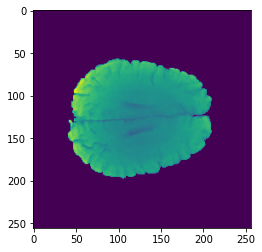

In [9]:
plt.imshow(np.frombuffer(o, dtype=np.float32).reshape((256,256,32,6))[:,:,20,0])

In [4]:
fastt2.tofile(f"results_v3/{model}-2245-simulations{mode}/MWF/fastt2_snr{SNR}.bin")

In [5]:
t = np.fromfile(f"results_v3/{model}-2245-simulations{mode}/MWF/fastt2_snr{SNR}.bin")

In [11]:
t.dtype

dtype('float64')

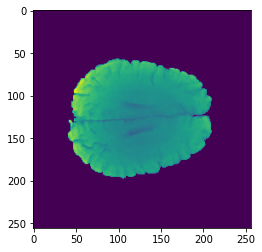

In [8]:
plt.imshow(t)

In [42]:
fastt2.min()

-5.3231201171875